In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import classification_report
from scipy import stats

Cleaning Dataframe

In [6]:
rawdata = pd.read_csv('2010.csv')
rawtest = pd.read_csv('2012.csv')
rawtest = rawtest[:100000]


incdata = pd.read_csv('pctToincome.csv')
incdata['perCapInc'] = incdata['perCapInc'].str.replace(',', '').fillna(-1)
incdata['perCapInc'] = incdata['perCapInc'].astype(int)
incdata['medHouseInc'] = incdata['medHouseInc'].str.replace(',', '').fillna(-1)
incdata['medHouseInc'] = incdata['medHouseInc'].astype(int)

merged_df = pd.merge(rawdata, incdata[['pct', 'perCapInc','medHouseInc']], on='pct')
rawdata['perCapInc'] = merged_df['perCapInc']
rawdata['medHouseInc'] = merged_df['medHouseInc']

mergedtest_df = pd.merge(rawtest, incdata[['pct', 'perCapInc','medHouseInc']], on='pct')
rawtest['perCapInc'] = mergedtest_df['perCapInc']
rawtest['medHouseInc'] = mergedtest_df['medHouseInc']

rawdata['usedForce'] = 'N'
rawdata.loc[(rawdata['pf_hands'] == 'Y') | (rawdata['pf_wall'] == 'Y') | (rawdata['pf_grnd'] == 'Y') | 
            (rawdata['pf_drwep'] == 'Y') |(rawdata['pf_baton'] == 'Y') | (rawdata['pf_ptwep'] == 'Y') |
            (rawdata['pf_hcuff'] == 'Y') |(rawdata['pf_pepsp'] == 'Y') |(rawdata['pf_other'] == 'Y'), 'usedForce'] = 'Y'

rawtest['usedForce'] = 'N'
rawtest.loc[(rawtest['pf_hands'] == 'Y') | (rawtest['pf_wall'] == 'Y') | (rawtest['pf_grnd'] == 'Y') | 
            (rawtest['pf_drwep'] == 'Y') |(rawtest['pf_baton'] == 'Y') | (rawtest['pf_ptwep'] == 'Y') |
            (rawtest['pf_hcuff'] == 'Y') |(rawtest['pf_pepsp'] == 'Y') |(rawtest['pf_other'] == 'Y'), 'usedForce'] = 'Y'

features = ['pct','frisked','searched','pistol','usedForce','cs_descr','sex','race','age','cs_vcrim','cs_bulge','medHouseInc']



datadf = rawdata[features]
testdf =rawtest[features]



C:\Users\danie\AppData\Local\Temp\ipykernel_19548\2165535676.py:1: DtypeWarning: Columns (73,74,102,109,110) have mixed types. Specify dtype option on import or set low_memory=False.
  rawdata = pd.read_csv('2010.csv')
C:\Users\danie\AppData\Local\Temp\ipykernel_19548\2165535676.py:2: DtypeWarning: Columns (10,73,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  rawtest = pd.read_csv('2012.csv')


Decision Tree

In [9]:
X = pd.get_dummies(datadf)
X_test = pd.get_dummies(testdf)
Y = rawdata['arstmade']
yTestTrue = rawtest['arstmade']
dTree = tree.DecisionTreeClassifier(max_depth=10)
dTree.fit(X,Y)
print("done making tree")
y_pred = dTree.predict(X_test)
output = pd.DataFrame({'serNum': rawtest.ser_num,'arrestMade': y_pred})
print(output)

treeAcc = round(dTree.score(X,Y) * 100,2)
print(treeAcc)

done making tree
       serNum arrestMade
0          17          N
1         691          N
2        3714          N
3         633          N
4          36          N
...       ...        ...
99995    5074          N
99996    5075          N
99997     524          N
99998     653          N
99999    1202          N

[100000 rows x 2 columns]
94.37


Calculating Precision, Recall, F-Score, AUC, and ROC Curve

              precision    recall  f1-score   support

           N       0.96      0.99      0.97     94383
           Y       0.61      0.28      0.39      5617

    accuracy                           0.95    100000
   macro avg       0.78      0.64      0.68    100000
weighted avg       0.94      0.95      0.94    100000

AUC: 0.6360728383555325


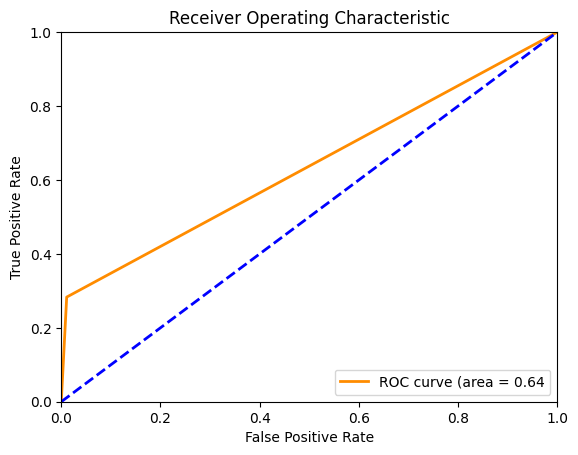

In [13]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

print(classification_report(yTestTrue,y_pred,zero_division=1))

predInt = np.where(y_pred == "Y",1,0)
intTest = rawtest.replace({"N":0, "Y":1})

fpr,tpr,threshold = roc_curve(intTest['arstmade'],predInt)
roc_auc = auc(fpr,tpr)
print("AUC:", roc_auc_score(intTest['arstmade'],predInt))
plt.plot(fpr,tpr,color='darkorange',lw=2, label ='ROC curve (area = %0.2f' %roc_auc)
plt.plot([0,1],[0,1],color='blue',lw=2,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix with True Positive, True Negative, False Positive, False Negative

In [25]:
from sklearn.metrics import confusion_matrix
#conf_mat = confusion_matrix(yTestTrue, y_pred)

cMdf = pd.DataFrame({'real': yTestTrue,'predicted':y_pred,'race':rawtest['race']})
blackCM = cMdf[(cMdf['race']=='B') | (cMdf['race'] == 'P')]
blackCMatrix = confusion_matrix(blackCM['real'], blackCM['predicted'])
btn, bfp, bfn, btp = blackCMatrix.ravel()
print("Black True negatives:", btn)
print("Black False positives:", bfp)
print("Black False negatives:", bfn)
print("Black True positives:", btp)
print()

whiteCM = cMdf[(cMdf['race']=='W')]
whiteCMatrix = confusion_matrix(whiteCM['real'], whiteCM['predicted'])
wtn, wfp, wfn, wtp = whiteCMatrix.ravel()
print("White True negatives:", wtn)
print("White False positives:", wfp)
print("White False negatives:", wfn)
print("White True positives:", wtp)
print()

asianCM = cMdf[(cMdf['race']=='A')]
asianCMatrix = confusion_matrix(asianCM['real'], asianCM['predicted'])
atn, afp, afn, atp = asianCMatrix.ravel()
print("Asian True negatives:", atn)
print("Asian False positives:", afp)
print("Asian False negatives:", afn)
print("Asian True positives:", atp)
print()

hispCM = cMdf[(cMdf['race']=='Q')]
hispCMatrix = confusion_matrix(hispCM['real'], hispCM['predicted'])
htn, hfp, hfn, htp = hispCMatrix.ravel()
print("Hispanic True negatives:", htn)
print("Hispanic False positives:", hfp)
print("Hispanic False negatives:", hfn)
print("Hispanic True positives:", htp)

Black True negatives: 56065
Black False positives: 626
Black False negatives: 2219
Black True positives: 965

White True negatives: 8168
White False positives: 84
White False negatives: 414
White True positives: 170

Asian True negatives: 2830
Asian False positives: 24
Asian False negatives: 157
Asian True positives: 66

Hispanic True negatives: 23434
Hispanic False positives: 259
Hispanic False negatives: 1118
Hispanic True positives: 348


Equal Opportunity

We are looking at FNR in the model. False Negative in our model is if the person was not arrested but the model predicted them to be arrested. 
There is equal opportunity in the decision tree model as the FNR across the different races are within 10% of one another. Black, White, and Asian are extremely close at only 1-2% difference. Hispanic was the only one that stood out at a 8% difference (bFNR/hFNR). 

In [28]:
#FN / (FN + TP)
bFNR = bfn/(bfn + btp)
wFNR = wfn/(wfn + wtp)
aFNR = afn/(afn + atp)
hFNR = hfn/(hfn + htp)

print("Black False Negative Rate:",bFNR)
print("White False Negative Rate:",wFNR)
print("Asian False Negative Rate:",aFNR)
print("Hispanic False Negative Rate:",hFNR)



Black False Negative Rate: 0.6969221105527639
White False Negative Rate: 0.708904109589041
Asian False Negative Rate: 0.7040358744394619
Hispanic False Negative Rate: 0.762619372442019
0.9138531431756278


Relaxation of Separation

We are looking at False Positive Rate (FPR) in the model. False Positive in our model is if the person was arrested but the model predicted them to not be arrested. 
There is relaxation of separation in the decision tree model as the FPR across the all races but asian is within 10% of one another. Black, White, and Hispanic are extremely close at only 1-2% difference. Asian was the only one that stood out at a 60% difference (aFPR/bFPR). There is inequality for the asian race. 

In [34]:
#FP / (FP + TN)
bFPR = bfp/(bfp + btn)
wFPR = wfp/(bfp + wtn)
aFPR = afp/(bfp + atn)
hFPR = hfp/(bfp + htn)

print("Black False Negative Rate:",bFPR)
print("White False Negative Rate:",wFPR)
print("Asian False Negative Rate:",aFPR)
print("Hispanic False Negative Rate:",hFPR)

print(aFPR/bFPR)


Black False Negative Rate: 0.011042317122647334
White False Negative Rate: 0.009551967250397999
Asian False Negative Rate: 0.006944444444444444
Hispanic False Negative Rate: 0.010764754779717374
0.628893769968051


Analyzing for Race

In [37]:
blackdf = rawdata[(rawdata['race']=='B') | (rawdata['race'] == 'P')]
print("Total Number of Black/African-American Stops: ", len(blackdf))
print("Percentage Searched or Frisked:",len(blackdf[(blackdf['frisked'] == 'Y') | (blackdf['searched'] == 'Y')])/len(blackdf))
print("Percentage Arrested or Summoned to court:",len(blackdf[(blackdf['arstmade'] == 'Y') | (blackdf['sumissue'] == 'Y')])/len(blackdf))
print("Percentage of Black/African-American in Dataset: ", len(blackdf)/len(rawdata))
print()

whitedf = rawdata[(rawdata['race']=='W')]
print("Total Number of White/Caucasian Stops: ", len(whitedf))
print("Percentage Searched or Frisked:",len(whitedf[(whitedf['frisked'] == 'Y') | (whitedf['searched'] == 'Y')])/len(whitedf))
print("Percentage Arrested or Summoned to court:",len(whitedf[(whitedf['arstmade'] == 'Y') | (whitedf['sumissue'] == 'Y')])/len(whitedf))
print("Percentage of White in Dataset: ", len(whitedf)/len(rawdata))
print()

asiandf = rawdata[(rawdata['race']=='A')]
print("Total Number of Asian Stops: ", len(asiandf))
print("Percentage Searched or Frisked:",len(asiandf[(asiandf['frisked'] == 'Y') | (asiandf['searched'] == 'Y')])/len(asiandf))
print("Percentage Arrested or Summoned to court:",len(asiandf[(asiandf['arstmade'] == 'Y') | (asiandf['sumissue'] == 'Y')])/len(asiandf))
print("Percentage of Asian in Dataset: ", len(asiandf)/len(rawdata))
print()

hispanicdf = rawdata[(rawdata['race']=='Q')]
print("Total Number of Hispanic Stops: ", len(hispanicdf))
print("Percentage Searched or Frisked:",len(hispanicdf[(hispanicdf['frisked'] == 'Y') | (hispanicdf['searched'] == 'Y')])/len(hispanicdf))
print("Percentage Arrested or Summoned to court:",len(hispanicdf[(hispanicdf['arstmade'] == 'Y') | (hispanicdf['sumissue'] == 'Y')])/len(hispanicdf))
print("Percentage of Hispanic in Dataset: ", len(hispanicdf)/len(rawdata))

Total Number of Black/African-American Stops:  353772
Percentage Searched or Frisked: 0.5832767997467295
Percentage Arrested or Summoned to court: 0.13559580746921746
Percentage of Black/African-American in Dataset:  0.5883599291517334

Total Number of White/Caucasian Stops:  54810
Percentage Searched or Frisked: 0.4451924831235176
Percentage Arrested or Summoned to court: 0.13641671227878124
Percentage of White in Dataset:  0.0911547768529067

Total Number of Asian Stops:  19732
Percentage Searched or Frisked: 0.46553821204135415
Percentage Arrested or Summoned to court: 0.14691871072369755
Percentage of Asian in Dataset:  0.032816384908986584

Total Number of Hispanic Stops:  150637
Percentage Searched or Frisked: 0.5921719099557213
Percentage Arrested or Summoned to court: 0.1417181701706752
Percentage of Hispanic in Dataset:  0.2505251253565281


Income Analysis 

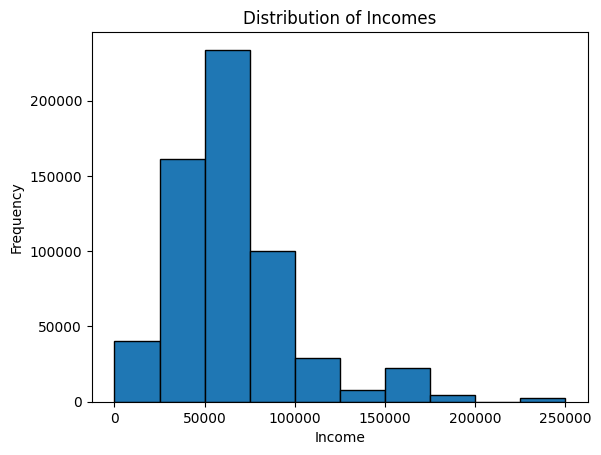

In [35]:
#rawdata 

plt.hist(rawdata['perCapInc'],bins=10,edgecolor="black")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.title("Distribution of Incomes")
plt.show()

Comparing High Income to overall dataset

In [45]:
highIncomedf = rawdata[rawdata['perCapInc'] >= 150000]

hiIncB = highIncomedf[(highIncomedf['race']=='B') | (highIncomedf['race'] == 'P')]
print("Total Number of Black/African-American Stops: ", len(hiIncB))
print("Percentage Searched or Frisked:",len(hiIncB[(hiIncB['frisked'] == 'Y') | (hiIncB['searched'] == 'Y')])/len(hiIncB))
print("Percentage Arrested or Summoned to court:",len(hiIncB[(hiIncB['arstmade'] == 'Y') | (hiIncB['sumissue'] == 'Y')])/len(hiIncB))
print("Percentage of Black/African-American in Dataset: ", len(hiIncB)/len(highIncomedf))
print()

hiIncW = highIncomedf[(highIncomedf['race']=='W')]
print("Total Number of White Stops: ", len(hiIncW))
print("Percentage Searched or Frisked:",len(hiIncW[(hiIncW['frisked'] == 'Y') | (hiIncW['searched'] == 'Y')])/len(hiIncW))
print("Percentage Arrested or Summoned to court:",len(hiIncW[(hiIncW['arstmade'] == 'Y') | (hiIncW['sumissue'] == 'Y')])/len(hiIncW))
print("Percentage of White in Dataset: ", len(hiIncW)/len(highIncomedf))
print()
hiIncA = highIncomedf[(highIncomedf['race']=='A')]
print("Total Number of Asian Stops: ", len(hiIncA))
print("Percentage Searched or Frisked:",len(hiIncA[(hiIncA['frisked'] == 'Y') | (hiIncA['searched'] == 'Y')])/len(hiIncA))
print("Percentage Arrested or Summoned to court:",len(hiIncA[(hiIncA['arstmade'] == 'Y') | (hiIncA['sumissue'] == 'Y')])/len(hiIncA))
print("Percentage of Asian in Dataset: ", len(hiIncA)/len(highIncomedf))
print()
hiIncH = highIncomedf[(highIncomedf['race']=='Q')]
print("Total Number of Hispanic Stops: ", len(hiIncH))
print("Percentage Searched or Frisked:",len(hiIncH[(hiIncH['frisked'] == 'Y') | (hiIncH['searched'] == 'Y')])/len(hiIncH))
print("Percentage Arrested or Summoned to court:",len(hiIncH[(hiIncH['arstmade'] == 'Y') | (hiIncH['sumissue'] == 'Y')])/len(hiIncH))
print("Percentage of Hispanic in Dataset: ", len(hiIncH)/len(highIncomedf))

Total Number of Black/African-American Stops:  17565
Percentage Searched or Frisked: 0.5902077996014802
Percentage Arrested or Summoned to court: 0.12183319100483916
Percentage of Black/African-American in Dataset:  0.6005128205128205

Total Number of White Stops:  2540
Percentage Searched or Frisked: 0.4519685039370079
Percentage Arrested or Summoned to court: 0.1283464566929134
Percentage of White in Dataset:  0.08683760683760684

Total Number of Asian Stops:  984
Percentage Searched or Frisked: 0.48272357723577236
Percentage Arrested or Summoned to court: 0.13516260162601626
Percentage of Asian in Dataset:  0.03364102564102564

Total Number of Hispanic Stops:  7031
Percentage Searched or Frisked: 0.6040392547290571
Percentage Arrested or Summoned to court: 0.13796046081638458
Percentage of Hispanic in Dataset:  0.24037606837606837


Comparing Low Income to overall dataset

In [44]:
lowIncomedf = rawdata[rawdata['perCapInc'] <= 25000]

lowIncB = lowIncomedf[(lowIncomedf['race']=='B') | (lowIncomedf['race'] == 'P')]
print("Total Number of Black/African-American Stops: ", len(lowIncB))
print("Percentage Searched or Frisked:",len(lowIncB[(lowIncB['frisked'] == 'Y') | (lowIncB['searched'] == 'Y')])/len(lowIncB))
print("Percentage Arrested or Summoned to court:",len(lowIncB[(lowIncB['arstmade'] == 'Y') | (lowIncB['sumissue'] == 'Y')])/len(lowIncB))
print("Percentage of Black/African-American in Dataset: ", len(lowIncB)/len(lowIncomedf))
print()

lowIncW = lowIncomedf[(lowIncomedf['race']=='W')]
print("Total Number of White Stops: ", len(lowIncW))
print("Percentage Searched or Frisked:",len(lowIncW[(lowIncW['frisked'] == 'Y') | (lowIncW['searched'] == 'Y')])/len(lowIncW))
print("Percentage Arrested or Summoned to court:",len(lowIncW[(lowIncW['arstmade'] == 'Y') | (lowIncW['sumissue'] == 'Y')])/len(lowIncW))
print("Percentage of White in Dataset: ", len(lowIncW)/len(lowIncomedf))
print()
lowIncA = lowIncomedf[(lowIncomedf['race']=='A')]
print("Total Number of Asian Stops: ", len(lowIncA))
print("Percentage Searched or Frisked:",len(lowIncA[(lowIncA['frisked'] == 'Y') | (lowIncA['searched'] == 'Y')])/len(lowIncA))
print("Percentage Arrested or Summoned to court:",len(lowIncA[(lowIncA['arstmade'] == 'Y') | (lowIncA['sumissue'] == 'Y')])/len(lowIncA))
print("Percentage of Asian in Dataset: ", len(lowIncA)/len(lowIncomedf))
print()
lowIncH = lowIncomedf[(lowIncomedf['race']=='Q')]
print("Total Number of Hispanic Stops: ", len(lowIncH))
print("Percentage Searched or Frisked:",len(lowIncH[(lowIncH['frisked'] == 'Y') | (lowIncH['searched'] == 'Y')])/len(lowIncH))
print("Percentage Arrested or Summoned to court:",len(lowIncH[(lowIncH['arstmade'] == 'Y') | (lowIncH['sumissue'] == 'Y')])/len(lowIncH))
print("Percentage of Hispanic in Dataset: ", len(lowIncH)/len(lowIncomedf))

Total Number of Black/African-American Stops:  23910
Percentage Searched or Frisked: 0.5980761187787537
Percentage Arrested or Summoned to court: 0.13304056879966542
Percentage of Black/African-American in Dataset:  0.5922568180129301

Total Number of White Stops:  3707
Percentage Searched or Frisked: 0.44807121661721067
Percentage Arrested or Summoned to court: 0.12489884003237119
Percentage of White in Dataset:  0.09182333853508706

Total Number of Asian Stops:  1298
Percentage Searched or Frisked: 0.4953775038520801
Percentage Arrested or Summoned to court: 0.13559322033898305
Percentage of Asian in Dataset:  0.03215179212801268

Total Number of Hispanic Stops:  10040
Percentage Searched or Frisked: 0.6098605577689243
Percentage Arrested or Summoned to court: 0.12559760956175298
Percentage of Hispanic in Dataset:  0.2486933690025018


Black             353772
White-Hispanic    150637
White              54810
Asian              19732
Name: race, dtype: int64
2010


,Stop Count,Stop Count Normalized
Black,353772,0.611057
White-Hispanic,150637,0.260190
White,54810,0.094671
Asian,19732,0.034082


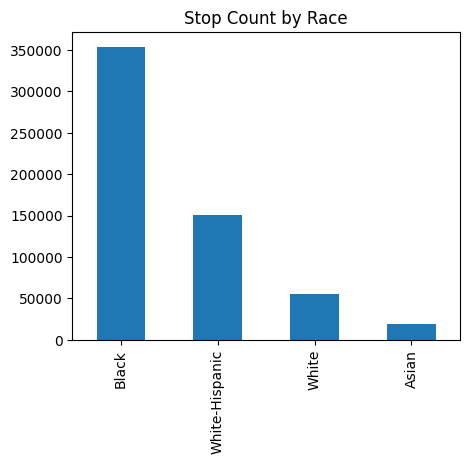

In [50]:
racedf = rawdata
racedf['race'] = rawdata['race'].replace(['B', 'P','Q', 'W', 'Z','A', 'U', 'I'], 
                                        ['Black', 'Black', 'White-Hispanic', 'White', 'Other','Asian', 'Unknown', 'American Indian/Alaskan Native'])
#Sample of other, unknown and American indian can be exlcluded
racedf.drop(racedf[(racedf['race'] == 'Other') | (racedf['race'] == 'Unknown') | (racedf['race'] == 'American Indian/Alaskan Native')].index,inplace= True  )

print(racedf["race"].value_counts())


print("2010")
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(4)
racedf["race"].value_counts().plot.bar(title ="Stop Count by Race")
pd.concat(
    [
        racedf["race"].value_counts(),
        racedf["race"].value_counts(normalize=True)
    ],
    keys=['Stop Count', 'Stop Count Normalized'],
    axis=1,
)

2010


,Stop Count,Stop Count Normalized
Black,353772,0.611057
White-Hispanic,150637,0.260190
White,54810,0.094671
Asian,19732,0.034082


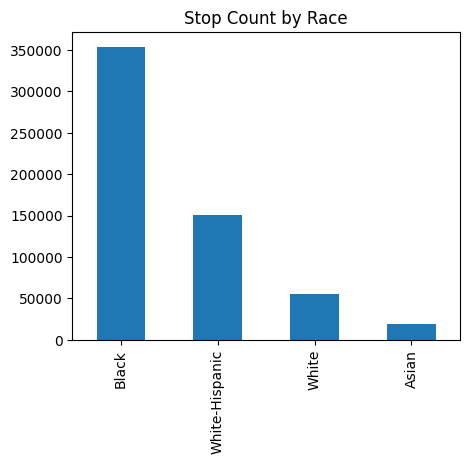

In [51]:
print("2010")
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(4)
racedf["race"].value_counts().plot.bar(title ="Stop Count by Race")
pd.concat(
    [
        racedf["race"].value_counts(),
        racedf["race"].value_counts(normalize=True)
    ],
    keys=['Stop Count', 'Stop Count Normalized'],
    axis=1,
)

                          Force used counts  Force used normalized
city      race                                                    
BRONX     Black                       66435               0.624765
          White-Hispanic              35778               0.336462
          White                        3303               0.031062
          Asian                         820               0.007711
BROOKLYN  Black                      136940               0.718329
          White-Hispanic              33560               0.176041
          White                       16650               0.087339
          Asian                        3487               0.018291
MANHATTAN Black                       75226               0.640947
          White-Hispanic              28249               0.240689
          White                       11377               0.096935
          Asian                        2515               0.021429
QUEENS    Black                       62802               0.45

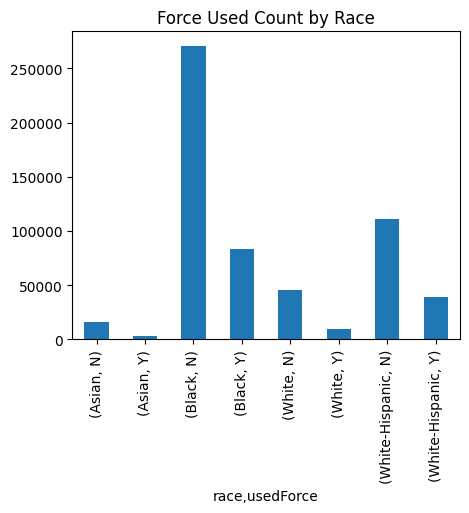

In [52]:
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(4)
racedf.groupby('race')["usedForce"].value_counts().plot.bar(title ="Force Used Count by Race")

#Count on race based on force used and city
city_ten_df = racedf[racedf.city != ' ' ]

print(pd.concat(
[
    
    city_ten_df.groupby('city')["race"].value_counts(),
    city_ten_df.groupby('city')["race"].value_counts(normalize= True),

],
keys=['Force used counts', 'Force used normalized'],
axis=1,
))